<a href="https://colab.research.google.com/github/kimys0925/3D_objectdetection/blob/main/MMT_%EC%A0%84%EC%B2%98%EB%A6%AC_%EB%B0%8F_%ED%95%99%EC%8A%B5%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q timm

import os, zipfile, shutil, glob, json, torch, re, cv2
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm
import timm
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ 사용 장치: {device}")

# 구글 드라이브 마운트
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

✅ 사용 장치: cuda


In [ ]:
import os, zipfile, shutil
from tqdm.auto import tqdm

# 1. 경로 설정 (사용자님의 드라이브 경로 기반)
drive_base_path = '/content/drive/MyDrive/dataset/3.개방데이터/1.데이터'
local_extract_path = '/content/dataset'  # 로컬에 저장될 최종 경로

# 2. 작업 대상 폴더 (Training, Validation)
target_subsets = ['Training', 'Validation']

def smart_extract(subset):
    # 예: /content/dataset/Training/source 형태의 폴더 생성
    source_extract_to = os.path.join(local_extract_path, subset, 'source')
    label_extract_to = os.path.join(local_extract_path, subset, 'label')

    os.makedirs(source_extract_to, exist_ok=True)
    os.makedirs(label_extract_to, exist_ok=True)

    # 드라이브 내 실제 zip 파일이 모여있는 경로
    subset_drive_path = os.path.join(drive_base_path, subset)

    # 01.원천데이터(bin)와 02.라벨링데이터(json) 하위의 모든 zip 찾기
    for category in ['01.원천데이터', '02.라벨링데이터']:
        target_dir = os.path.join(subset_drive_path, category)
        if not os.path.exists(target_dir):
            continue

        # 하위 폴더까지 뒤져서 모든 .zip 파일 목록 가져오기
        zip_files = []
        for root, dirs, files in os.walk(target_dir):
            for file in files:
                if file.endswith('.zip'):
                    zip_files.append(os.path.join(root, file))

        print(f"📦 {subset} - {category}: {len(zip_files)}개의 압축파일 발견")

        # 압축 해제 타겟 결정
        final_destination = source_extract_to if '원천' in category else label_extract_to

        for z_path in tqdm(zip_files, desc=f"Extracting {category}"):
            try:
                with zipfile.ZipFile(z_path, 'r') as z:
                    z.extractall(final_destination)
            except Exception as e:
                print(f"⚠️ {os.path.basename(z_path)} 해제 실패: {e}")

# --- 실행 부분 ---
# 이미 압축이 풀려있는지 확인 (시간 절약용)
if not os.path.exists(local_extract_path):
    print("🚀 압축 해제를 시작합니다. (수만 장의 데이터이므로 시간이 걸릴 수 있습니다)")
    for subset in target_subsets:
        smart_extract(subset)
    print("\n✅ 모든 데이터가 로컬(/content/dataset)에 준비되었습니다!")
else:
    print("✅ 이미 로컬에 데이터가 존재합니다. 압축 해제를 건너뜁니다.")

✅ 이미 로컬에 데이터가 존재합니다. 압축 해제를 건너뜁니다.


In [ ]:
import pandas as pd
import glob
import os
import re  # 정규표현식 라이브러리 추가 (re.findall 사용을 위해 필수)
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# [필수] 1. 함수 정의 (이 부분이 먼저 실행되어야 합니다)
def create_final_manifest(subset='Training'):
    # 실제 데이터 경로에 맞게 수정하세요
    source_root = f'/content/dataset/{subset}/source'
    label_root = f'/content/dataset/{subset}/label'

    print(f"🔍 {subset} 데이터 매칭 시작...")

    all_bins = glob.glob(os.path.join(source_root, "**/*.bin"), recursive=True)
    all_csvs = glob.glob(os.path.join(source_root, "**/*.csv"), recursive=True)
    all_jsons = glob.glob(os.path.join(label_root, "**/*.json"), recursive=True)

    def get_id(path):
        fname = os.path.basename(path).split('.')[0]
        return fname.replace('TS_', '').replace('TL_', '')

    bin_dict = {get_id(f): f for f in all_bins}
    csv_dict = {get_id(f): f for f in all_csvs}

    matched_data = []
    for j_path in tqdm(all_jsons, desc=f"Matching {subset} JSON"):
        jid = get_id(j_path)
        if jid in bin_dict and jid in csv_dict:
            matched_data.append({
                'id': jid,
                'bin': bin_dict[jid],
                'csv': csv_dict[jid],
                'json': j_path
            })

    print(f"✅ {subset} 매칭 완료: 총 {len(matched_data)}개 세트 확보!")
    return matched_data

# [필수] 2. 나머지 로직 실행
print("🔍 전체 폴더(Training + Validation) 통합 매칭 시작...")
train_all = create_final_manifest('Training')
val_all = create_final_manifest('Validation')

# 통합 및 분할 로직 계속...
full_matched_list = train_all + val_all

🔍 전체 폴더(Training + Validation) 통합 매칭 시작...
🔍 Training 데이터 매칭 시작...


Matching Training JSON:   0%|          | 0/99476 [00:00<?, ?it/s]

✅ Training 매칭 완료: 총 99476개 세트 확보!
🔍 Validation 데이터 매칭 시작...


Matching Validation JSON:   0%|          | 0/12394 [00:00<?, ?it/s]

✅ Validation 매칭 완료: 총 12394개 세트 확보!


In [ ]:
import torch
import json
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class PdMDataset(Dataset):
    def __init__(self, matched_list, seq_len=50):
        self.data_list = matched_list
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        try:
            # 1. 진동 데이터 (정상 확인됨)
            v_raw = np.fromfile(item['bin'], dtype=np.int16)
            v_data = v_raw[:self.seq_len * 3].reshape(self.seq_len, 3).astype(np.float32)

            # 2. 전류 데이터 (수정): 데이터가 일정해도 0이 되지 않게 처리
            c_df = pd.read_csv(item['csv'])
            c_seq = c_df['CT1'].values.astype(np.float32)

            if len(c_seq) >= self.seq_len:
                c_data = c_seq[:self.seq_len]
            else:
                c_data = np.pad(c_seq, (0, self.seq_len - len(c_seq)), 'edge')
            c_data = c_data.reshape(self.seq_len, 1)

            # 3. 라벨 데이터 (성공 확인됨)
            with open(item['json'], 'r', encoding='utf-8') as f:
                js = json.load(f)
                state = js['annotations'][0]['tagging'][0]['state']
                label = float(state)

            # 4. 정규화 로직 보완
            # 진동 정규화
            v_data = (v_data - np.mean(v_data)) / (np.std(v_data) + 1e-7)

            # 전류 정규화: 값이 모두 같을 경우(std=0) 정규화 생략
            c_std = np.std(c_data)
            if c_std > 1e-6:
                c_data = (c_data - np.mean(c_data)) / (c_std + 1e-7)
            else:
                # 값이 일정하면 평균만 빼거나 그대로 둡니다 (0 방지)
                # 여기서는 원본 수치 범위를 줄이기 위해 10으로 나눠줍니다.
                c_data = c_data / 10.0

        except Exception as e:
            v_data = np.zeros((self.seq_len, 3), dtype=np.float32)
            c_data = np.zeros((self.seq_len, 1), dtype=np.float32)
            label = 0.0

        return torch.FloatTensor(v_data), torch.FloatTensor(c_data), torch.FloatTensor([label])

In [ ]:
import os
from torch.utils.data import DataLoader

# 1. 워커 수 설정 (에러 방지를 위해 2로 고정)
# num_cpus 대신 직접 숫자를 지정하여 안정성을 높입니다.
WORKERS = 2

# 2. Train / Val / Test 로더 설정
# batch_size=64: 모델 학습 속도와 메모리 효율의 밸런스를 맞춥니다.
BATCH_SIZE = 64

train_loader = DataLoader(
    PdMDataset(train_list),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    PdMDataset(val_list),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    PdMDataset(test_list),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True
)

print(f"✅ 로더 설정 완료! (Workers: {WORKERS})")
print(f"📦 배치 개수: {len(train_loader)} (총 {len(train_list)}개 데이터)")

✅ 로더 설정 완료! (Workers: 2)
📦 배치 개수: 1361 (총 87082개 데이터)


In [ ]:
# 1. 모든 폴더(Training, Validation)의 데이터를 하나로 통합 매칭
print("🔍 전체 폴더(Training + Validation) 통합 매칭 시작...")
train_all = create_final_manifest('Training')
val_all = create_final_manifest('Validation')

# 두 리스트를 하나로 합칩니다.
full_matched_list = train_all + val_all
print(f"📊 통합 매칭 완료: 총 {len(full_matched_list)}개 세트 확보")

# 2. 통합 리스트를 ID 규칙에 따라 분할
def split_manifest_by_id_final(matched_list):
    train_list, val_list, test_list = [], [], []

    for item in matched_list:
        numbers = re.findall(r'\d+', item['id'])
        if numbers:
            id_num = int(numbers[0])

            # 사용자님의 지정 규칙 적용
            if 1 <= id_num <= 14:
                train_list.append(item)
            elif 15 <= id_num <= 16:
                val_list.append(item)
            elif 17 <= id_num <= 18:
                test_list.append(item)
            else:
                # 혹시나 18번을 넘어가는 ID가 있다면 Test에 포함
                test_list.append(item)

    return train_list, val_list, test_list

# 분할 실행
train_list, val_list, test_list = split_manifest_by_id_final(full_matched_list)

print("\n--- [최종 ID 기반 분할 결과] ---")
print(f"🚜 Train (ID 01~14): {len(train_list)}개")
print(f"🧪 Val   (ID 15~16): {len(val_list)}개")
print(f"🏁 Test  (ID 17~18): {len(test_list)}개")

# 3. 데이터 로더 최종 생성
train_dataset = PdMDataset(train_list)
val_dataset = PdMDataset(val_list)
test_dataset = PdMDataset(test_list)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("\n✅ 이제 17, 18번 데이터까지 완벽하게 로드되었습니다! 학습 준비 끝!")

🔍 전체 폴더(Training + Validation) 통합 매칭 시작...
🔍 Training 데이터 매칭 시작...


Matching Training JSON:   0%|          | 0/99476 [00:00<?, ?it/s]

✅ Training 매칭 완료: 총 99476개 세트 확보!
🔍 Validation 데이터 매칭 시작...


Matching Validation JSON:   0%|          | 0/12394 [00:00<?, ?it/s]

✅ Validation 매칭 완료: 총 12394개 세트 확보!
📊 통합 매칭 완료: 총 111870개 세트 확보

--- [최종 ID 기반 분할 결과] ---
🚜 Train (ID 01~14): 87082개
🧪 Val   (ID 15~16): 12394개
🏁 Test  (ID 17~18): 12394개

✅ 이제 17, 18번 데이터까지 완벽하게 로드되었습니다! 학습 준비 끝!


In [ ]:
class MMTRegression(nn.Module):
    def __init__(self, v_dim=3, c_dim=1, d_model=128, nhead=8, num_layers=3):
        super(MMTRegression, self).__init__()
        self.v_emb = nn.Linear(v_dim, d_model)
        self.c_emb = nn.Linear(c_dim, d_model)

        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.v_transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.c_transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Linear(d_model * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, v, c):
        v_feat = self.v_transformer(self.v_emb(v))
        c_feat = self.c_transformer(self.c_emb(c))
        combined = torch.cat((torch.mean(v_feat, dim=1), torch.mean(c_feat, dim=1)), dim=1)
        return self.regressor(combined)

--- [디버깅 정보: 인덱스 500] ---
ID: agv10_0903_053528

[진동 데이터]
- 원본 데이터 처음 10개: [2.2366853e+08 1.2387478e-40 3.4833497e-15 4.4898648e+21 1.5767864e-19
 5.4892294e-05 2.2228396e-15 7.6830766e+31 1.7177136e+19 6.7425655e+22]
- 데이터 최소값: nan, 최대값: nan
- 데이터 총 개수: 38432 (예상: 150=150)

[전류 데이터 CSV 구조]
- CSV 컬럼명: ['NTC', 'PM1.0', 'PM2.5', 'PM10', 'CT1', 'CT2', 'CT3', 'CT4']
- CSV 상단 5줄:


,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4
0,41.01,34.0,45.0,81.0,7.81,75.11,49.92,20.03



[라벨 데이터 JSON]
- JSON 전체 내용: {'meta_info': [{'device_id': 'agv10', 'device_manufacturer': 'C', 'device_name': 'C1', 'dust_sensor_manufacturer': 'S01', 'dust_sensor_name': 'S02', 'temp_sensor_manufacturer': 'S09', 'temp_sensor_name': 'S10', 'overcurrent_sensor_manufacturer': 'S17', 'overcurrent_sensor_name': 'S18', 'thermal_camera_sensor_manufacturer': 'S25', 'thermal_camera_sensor_name': 'S26', 'installation_environment': '테스트베드', 'collection_date': '09-03', 'collection_time': '05:35:28', 'duration_time': '1', 'sensor_types': 'NTC, PM10, PM2.5, PM1.0, CT1, CT2, CT3, CT4', 'cumulative_operating_day': '13', 'equipment_history': '7', 'img-id': 'agv10_0903_053528', 'location': 'agv/10/agv10_0903_0535', 'filename': 'agv10_0903_053528.json', 'img_name': 'agv10_0903_053528.bin', 'img_description': 'agv10의 현재 내부 온도(최대값)'}], 'sensor_data': [{'PM10': [{'data_unit': 'µg/m3', 'value': 81.0, 'trend': '1'}], 'PM2.5': [{'data_unit': 'µg/m3', 'value': 45.0, 'trend': '1'}], 'PM1.0': [{'data_unit': 'µg/

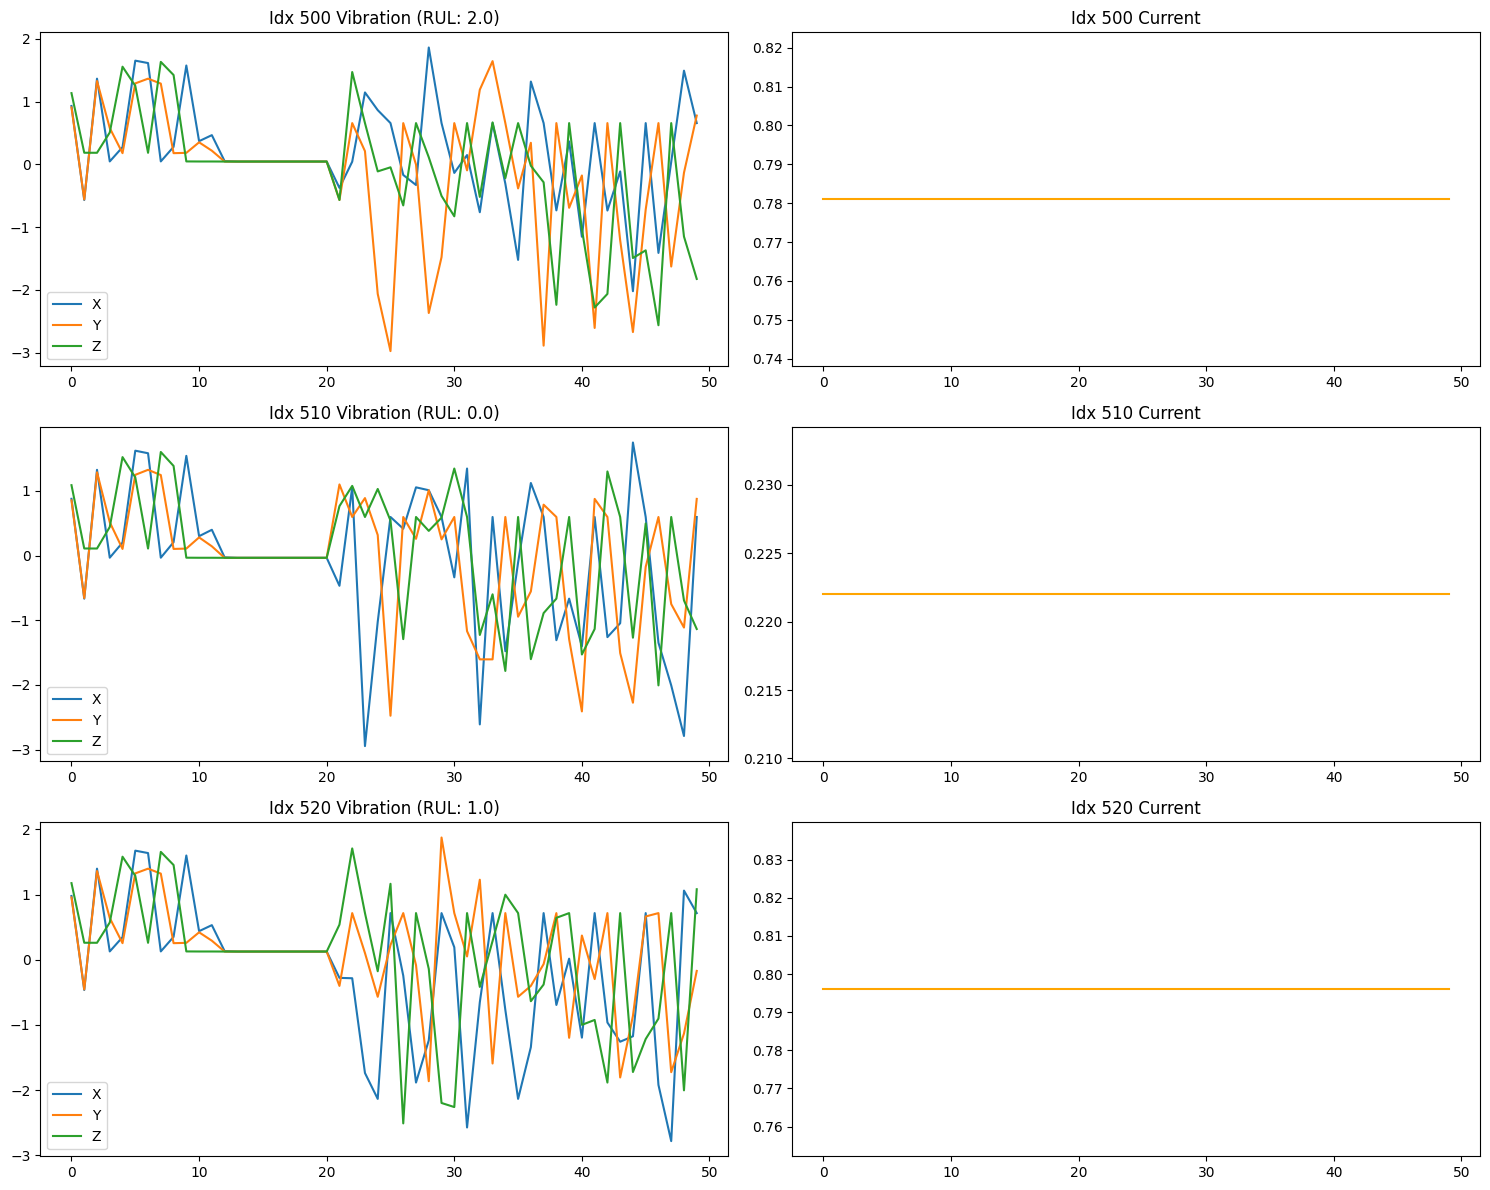

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

def debug_data_structure(matched_list, sample_idx=500):
    item = matched_list[sample_idx]
    print(f"--- [디버깅 정보: 인덱스 {sample_idx}] ---")
    print(f"ID: {item['id']}")

    # 1. 진동 데이터 (.bin) 원본 수치 확인
    v_raw = np.fromfile(item['bin'], dtype=np.float32)
    print(f"\n[진동 데이터]")
    print(f"- 원본 데이터 처음 10개: {v_raw[:10]}")
    print(f"- 데이터 최소값: {np.min(v_raw)}, 최대값: {np.max(v_raw)}")
    print(f"- 데이터 총 개수: {len(v_raw)} (예상: {50*3}=150)")

    # 2. 전류 데이터 (.csv) 구조 및 첫 5줄 확인
    print(f"\n[전류 데이터 CSV 구조]")
    c_df = pd.read_csv(item['csv'])
    print("- CSV 컬럼명:", c_df.columns.tolist())
    print("- CSV 상단 5줄:")
    display(c_df.head(5)) # 코랩에서 표 형태로 출력

    # 3. 라벨 데이터 (.json) 내용 확인
    print(f"\n[라벨 데이터 JSON]")
    with open(item['json'], 'r') as f:
        label_data = json.load(f)
        print("- JSON 전체 내용:", label_data)

    # 4. 시각화 (여러 샘플 동시 확인)
    check_indices = [sample_idx, sample_idx + 10, sample_idx + 20]
    fig, axes = plt.subplots(len(check_indices), 2, figsize=(15, 12))

    for i, idx in enumerate(check_indices):
        v, c, y = train_dataset[idx]

        # 진동 그래프
        axes[i, 0].plot(v[:, 0], label='X')
        axes[i, 0].plot(v[:, 1], label='Y')
        axes[i, 0].plot(v[:, 2], label='Z')
        axes[i, 0].set_title(f"Idx {idx} Vibration (RUL: {y.item()})")
        axes[i, 0].legend()

        # 전류 그래프
        axes[i, 1].plot(c, color='orange')
        axes[i, 1].set_title(f"Idx {idx} Current")

    plt.tight_layout()
    plt.show()

# --- 실행 ---
# train_list가 생성된 상태에서 실행하세요.
debug_data_structure(train_list, sample_idx=500)

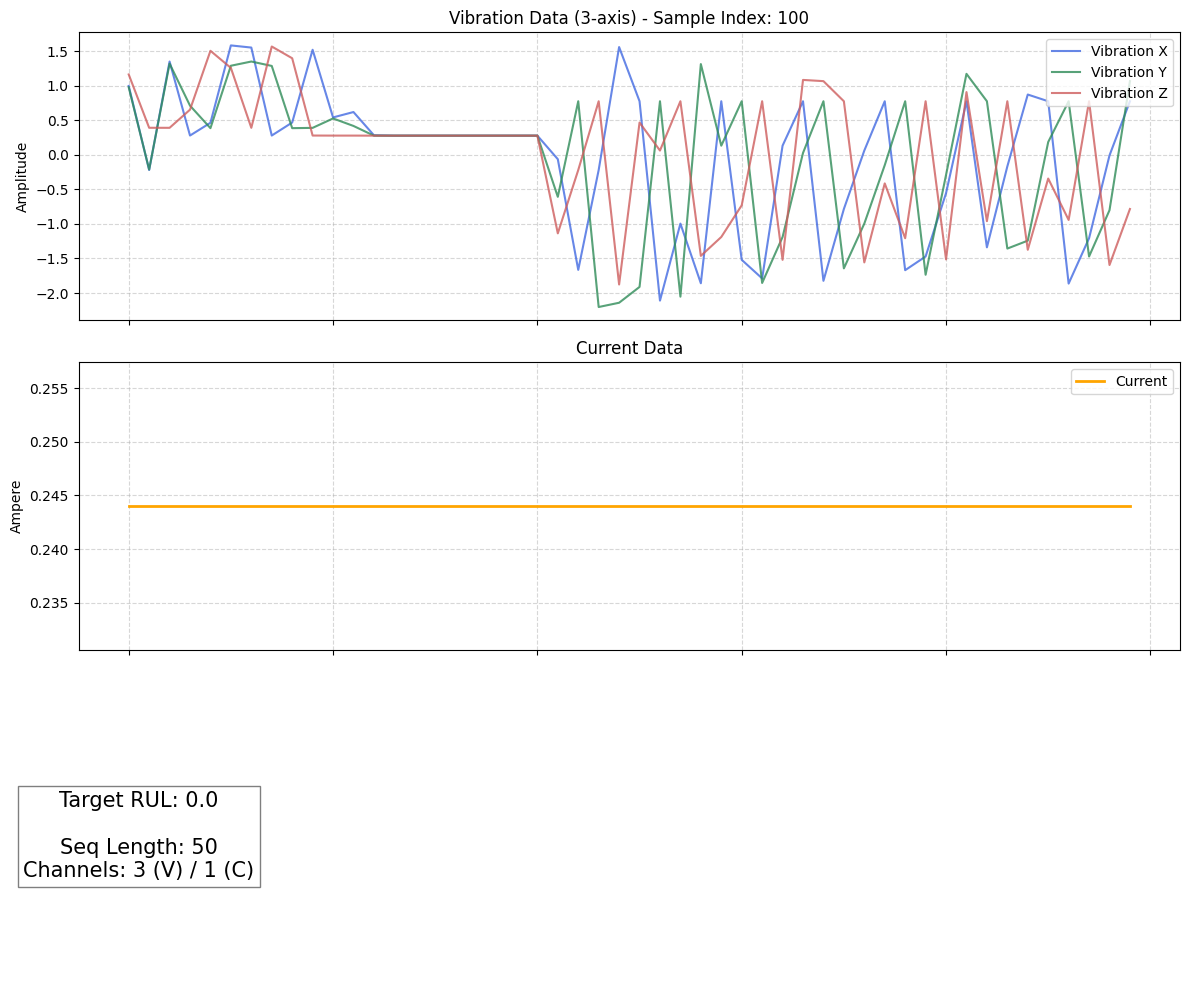

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(dataset, sample_idx=0):
    # 데이터셋에서 샘플 하나 추출
    v_data, c_data, label = dataset[sample_idx]

    # 텐서를 넘파이 배열로 변환
    v_data = v_data.numpy()
    c_data = c_data.numpy()
    label = label.item()

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # 1. 진동 데이터 시각화 (3축)
    time_steps = np.arange(v_data.shape[0])
    axes[0].plot(time_steps, v_data[:, 0], label='Vibration X', color='royalblue', alpha=0.8)
    axes[0].plot(time_steps, v_data[:, 1], label='Vibration Y', color='seagreen', alpha=0.8)
    axes[0].plot(time_steps, v_data[:, 2], label='Vibration Z', color='indianred', alpha=0.8)
    axes[0].set_title(f"Vibration Data (3-axis) - Sample Index: {sample_idx}")
    axes[0].set_ylabel("Amplitude")
    axes[0].legend(loc='upper right')
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # 2. 전류 데이터 시각화 (1축)
    axes[1].plot(time_steps, c_data, label='Current', color='orange', linewidth=2)
    axes[1].set_title("Current Data")
    axes[1].set_ylabel("Ampere")
    axes[1].legend(loc='upper right')
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # 3. 정보 출력 및 라벨 확인
    axes[2].text(0.5, 0.5, f"Target RUL: {label}\n\nSeq Length: {len(time_steps)}\nChannels: {v_data.shape[1]} (V) / {c_data.shape[1]} (C)",
                 fontsize=15, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- 실행 ---
# 무작위로 0번 샘플 확인 (다른 샘플을 보려면 인덱스를 바꿔보세요)
visualize_sample(train_dataset, sample_idx=100)

In [ ]:
# train_dataset이 정의된 상태에서 실행하세요
sample_idx = 500  # 아까 보신 500번 인덱스
v, c, y = train_dataset[sample_idx]

print(f"--- [최종 데이터 검증] ---")
print(f"인덱스 {sample_idx}의 실제 정답 값: {y.item()}")
print(f"전류 데이터 평균: {c.mean().item():.4f}")

--- [최종 데이터 검증] ---
인덱스 500의 실제 정답 값: 2.0
전류 데이터 평균: 0.7810


In [ ]:
# 실제 데이터셋에서 샘플 하나를 직접 꺼내봅니다.
v, c, y = train_dataset[500]

print("--- [최종 데이터 체크] ---")
print(f"1. 진동 텐서 모양: {v.shape}") # (50, 3) 나와야 함
print(f"2. 전류 텐서 모양: {c.shape}") # (50, 1) 나와야 함
print(f"3. 실제 라벨 값: {y.item()}")   # 여기서 1.0 또는 2.0이 나오면 성공!
print(f"4. 전류 값 일부: {c[:5].flatten().numpy()}") # 수치가 0이 아닌지 확인

--- [최종 데이터 체크] ---
1. 진동 텐서 모양: torch.Size([50, 3])
2. 전류 텐서 모양: torch.Size([50, 1])
3. 실제 라벨 값: 2.0
4. 전류 값 일부: [0.781 0.781 0.781 0.781 0.781]


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os

# 1. 성능 최적화 데이터 로더 설정
# num_workers를 2로 직접 지정하여 'AssertionError'를 방지합니다.
WORKERS = 2
BATCH_SIZE = 64

train_dataset = PdMDataset(train_list)
val_dataset = PdMDataset(val_list)
test_dataset = PdMDataset(test_list)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=WORKERS, pin_memory=True)

# 2. 모델 및 학습 도구
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MMTRegression(v_dim=3, c_dim=1).to(device)

# --- 여기 lr 부분을 0.0001로 수정하세요! ---
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
# ----------------------------------------

criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 자동 혼합 정밀도(AMP) 설정 - 연산 속도 대폭 향상
scaler = torch.amp.GradScaler('cuda')

# 3. Early Stopping 변수
epochs = 50
patience = 10
best_val_loss = float('inf')
counter = 0

print(f"🚀 최적화 모드로 학습 시작 (Workers: {WORKERS}, Batch: {BATCH_SIZE})")

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] [Train]", leave=False)

    for v, c, y in train_pbar:
        v, c, y = v.to(device, non_blocking=True), c.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # AMP 적용 (FP16 연산으로 속도 향상)
        with torch.amp.autocast('cuda'):
            pred = model(v, c)
            loss = criterion(pred, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        current_loss = loss.item()
        train_loss += current_loss
        train_pbar.set_postfix(loss=f"{current_loss:.4f}")

    avg_train_loss = train_loss / len(train_loader)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{epochs}] [Val]", leave=False)

    with torch.no_grad():
        for v, c, y in val_pbar:
            v, c, y = v.to(device, non_blocking=True), c.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with torch.amp.autocast('cuda'):
                v_loss = criterion(model(v, c), y).item()
            val_loss += v_loss
            val_pbar.set_postfix(loss=f"{v_loss:.4f}")

    avg_val_loss = val_loss / len(val_loader)

    # 스케줄러 단계 업데이트
    scheduler.step(avg_val_loss)

    print(f"✅ Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    # --- Early Stopping Logic ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_mmt_model.pt')
        counter = 0
        print("   -> ⭐ Best 모델 갱신 및 저장 완료")
    else:
        counter += 1
        if counter >= patience:
            print(f"🛑 Early Stopping 발생! {epoch+1} 에폭에서 중단합니다.")
            break

# 4. 최종 평가 (Test)
print("\n🔍 최종 테스트 데이터 평가 시작...")
model.load_state_dict(torch.load('best_mmt_model.pt'))
model.eval()
final_test_loss = 0
test_pbar = tqdm(test_loader, desc="[Final Test]")

with torch.no_grad():
    for v, c, y in test_pbar:
        v, c, y = v.to(device), c.to(device), y.to(device)
        final_test_loss += criterion(model(v, c), y).item()

print(f"✅ 최종 Test MSE Loss: {final_test_loss/len(test_loader):.4f}")

🚀 최적화 모드로 학습 시작 (Workers: 2, Batch: 64)


Epoch [1/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Epoch [1/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [1/50] | Train Loss: 0.8434 | Val Loss: 0.8906 | LR: 0.000100
   -> ⭐ Best 모델 갱신 및 저장 완료


Epoch [2/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [2/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [2/50] | Train Loss: 0.7999 | Val Loss: 0.8586 | LR: 0.000100
   -> ⭐ Best 모델 갱신 및 저장 완료


Epoch [3/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [3/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^

✅ Epoch [3/50] | Train Loss: 0.7802 | Val Loss: 0.8678 | LR: 0.000100


Epoch [4/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^

Epoch [4/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>

 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
    ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^

✅ Epoch [4/50] | Train Loss: 0.7619 | Val Loss: 0.8078 | LR: 0.000100
   -> ⭐ Best 모델 갱신 및 저장 완료


Epoch [5/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): Exception ignored in: 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>  
  Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line

Epoch [5/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [5/50] | Train Loss: 0.7448 | Val Loss: 0.7993 | LR: 0.000100
   -> ⭐ Best 모델 갱신 및 저장 완료


Epoch [6/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Epoch [6/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [6/50] | Train Loss: 0.7351 | Val Loss: 0.8061 | LR: 0.000100


Epoch [7/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [7/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [7/50] | Train Loss: 0.7322 | Val Loss: 0.7745 | LR: 0.000100
   -> ⭐ Best 모델 갱신 및 저장 완료


Epoch [8/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [8/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [8/50] | Train Loss: 0.7256 | Val Loss: 0.7674 | LR: 0.000100
   -> ⭐ Best 모델 갱신 및 저장 완료


Epoch [9/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [9/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()
AssertionError
:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
can o

✅ Epoch [9/50] | Train Loss: 0.7220 | Val Loss: 0.8107 | LR: 0.000100


Epoch [10/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^  ^ ^ 
   File "/usr/lib/

Epoch [10/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ 

✅ Epoch [10/50] | Train Loss: 0.7185 | Val Loss: 0.7948 | LR: 0.000100


Epoch [11/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480><function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    
    Traceback (most recent call last):
self._shutdown_workers()self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in 

Epoch [11/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [11/50] | Train Loss: 0.7124 | Val Loss: 0.7793 | LR: 0.000100


Epoch [12/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Epoch [12/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [12/50] | Train Loss: 0.7117 | Val Loss: 0.8158 | LR: 0.000100


Epoch [13/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [13/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [13/50] | Train Loss: 0.7089 | Val Loss: 0.7949 | LR: 0.000100


Epoch [14/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
      ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^

Epoch [14/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [14/50] | Train Loss: 0.7062 | Val Loss: 0.8047 | LR: 0.000050


Epoch [15/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 163

Epoch [15/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():
^ ^

✅ Epoch [15/50] | Train Loss: 0.6916 | Val Loss: 0.7940 | LR: 0.000050


Epoch [16/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch [16/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

              ^ ^ ^  ^^^^^^^^^^^^^^^^^^
^  

✅ Epoch [16/50] | Train Loss: 0.6878 | Val Loss: 0.7891 | LR: 0.000050


Epoch [17/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7df1ac1b6480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^  ^^^^^^

Epoch [17/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [17/50] | Train Loss: 0.6863 | Val Loss: 0.7971 | LR: 0.000050


Epoch [18/50] [Train]:   0%|          | 0/1361 [00:00<?, ?it/s]

Epoch [18/50] [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ Epoch [18/50] | Train Loss: 0.6842 | Val Loss: 0.7997 | LR: 0.000050
🛑 Early Stopping 발생! 18 에폭에서 중단합니다.

🔍 최종 테스트 데이터 평가 시작...


[Final Test]:   0%|          | 0/194 [00:00<?, ?it/s]

✅ 최종 Test MSE Loss: 0.8492
